<a href="https://colab.research.google.com/github/JISSJOHNSON/T-Flow/blob/master/T_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip3 install geopandas
!pip3 install keras
!pip3 install sklearn

    100% |████████████████████████████████| 931kB 20.3MB/s 
    100% |████████████████████████████████| 17.9MB 1.4MB/s 
    100% |████████████████████████████████| 10.8MB 2.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gplt 
import time
import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.data import Dataset
import keras
from keras.utils import to_categorical
from keras import models
from keras import layers

from datetime import datetime 
from math import sin, cos, sqrt, atan2, radians

Using TensorFlow backend.


In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
#now the filesystem is mapped to google drive
# time to load the data

data = pd.read_csv("/content/gdrive/My Drive/MainProject_BTech/T-Flow/Dataset/Raw_count_data_major_roads.csv")

#just making sure all the data is sorted base on the time 
data = data.sort_values("dCount")
data.head()

,Region Name (GO),ONS LACode,ONS LA Name,CP,S Ref E,S Ref N,S Ref Latitude,S Ref Longitude,Road,A-Junction,...,BUS,LGV,HGVR2,HGVR3,HGVR4,HGVA3,HGVA5,HGVA6,HGV,AMV
30300,London,E09000016,Havering,38647,551469,189000,51.579516,0.184617,A1251,A125,...,97,80,16.0,2,0.0,3.0,2,0.0,23.0,556.0
3507,East Midlands,E10000024,Nottinghamshire,27377,470000,357140,53.106871,-0.955826,A617,A614,...,0,40,17.0,1,1.0,2.0,10,6.0,37.0,266.0
3506,East Midlands,E10000024,Nottinghamshire,27377,470000,357140,53.106871,-0.955826,A617,A614,...,1,39,19.0,2,5.0,7.0,9,1.0,43.0,268.0
3505,East Midlands,E10000024,Nottinghamshire,27377,470000,357140,53.106871,-0.955826,A617,A614,...,2,65,25.0,1,2.0,5.0,4,3.0,40.0,332.0
3504,East Midlands,E10000024,Nottinghamshire,27377,470000,357140,53.106871,-0.955826,A617,A614,...,1,62,9.0,2,1.0,6.0,7,5.0,30.0,274.0


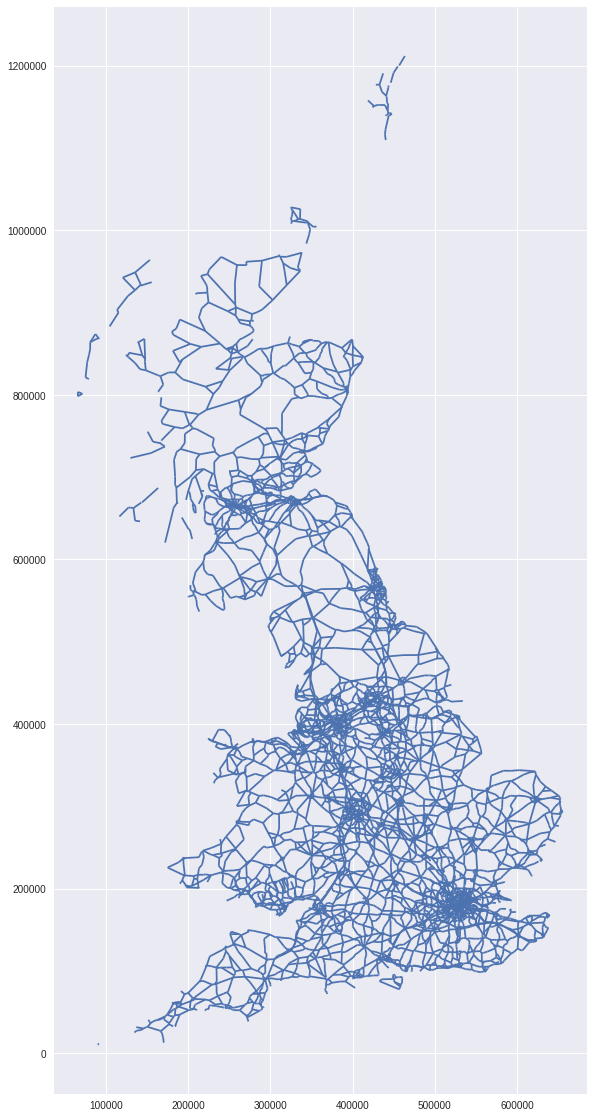

In [12]:
#plot the map of the data
%matplotlib inline

map_data = gplt.read_file('/content/gdrive/My Drive/MainProject_BTech/T-Flow/Map/major-roads-link-network2017.shp')
map_data.plot(figsize=(20,20))

In [13]:
#just need to see all the columns
for i in data.columns:
        print(i)

Region Name (GO)
ONS LACode
ONS LA Name
CP
S Ref E
S Ref N
S Ref Latitude
S Ref Longitude
Road
A-Junction
A Ref E
A Ref N
B-Junction
B Ref E
B Ref N
RCat
iDir
Year
dCount
Hour
PC
2WMV
CAR
BUS
LGV
HGVR2
HGVR3
HGVR4
HGVA3
HGVA5
HGVA6
HGV
AMV


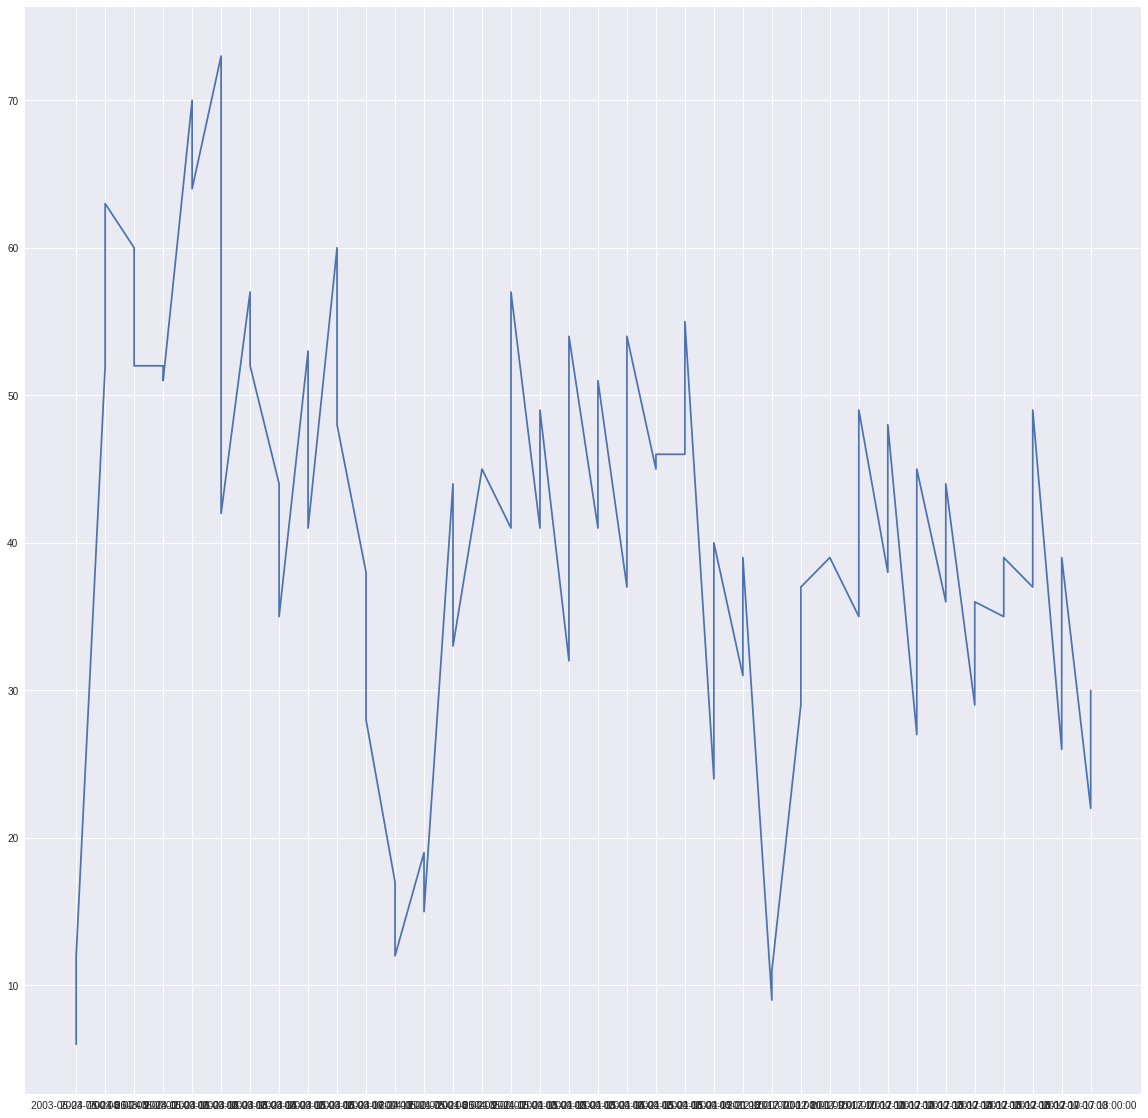

In [14]:
%matplotlib inline

subframe = data[['AMV','CP','dCount','Hour','Road','A-Junction','B-Junction']].sort_values(['dCount','A-Junction','B-Junction','Hour'])
d = subframe.groupby('CP')

#just outputing one graph 

from operator import add

for key, group in d:
    plt.figure(figsize=(20,20))
    
    l = list(group['dCount'])
    k =  list( map( lambda x : ' '+str(x)+':00:00 ', list(group['Hour'])) )
    s = list( map(add, l, k) )
    
    plt.plot(s, list(group['AMV']) ,label="Cars over year ")
    plt.show()
    break

In [0]:
def findDist(lat1, lon1, lat2, lon2):
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

def eastingDistance(x1,y1,x2,y2):
    return sqrt( pow(x2-x1,2) + pow(y2-y1,2) )

uniqueCP = list(data.CP.unique())
distanceMatrix = np.zeros(shape=(len(uniqueCP),len(uniqueCP)))

su_df = data.drop_duplicates('CP')[['CP','S Ref Latitude','S Ref Longitude','A-Junction','A Ref E','A Ref N','B-Junction','B Ref E','B Ref N']]
matrixq = None
c = 0;

In [0]:
#util function to calculate distance

# for index,row in su_df.iterrows():
    
#     primaryIndex = uniqueCP.index(row['CP'])
#     print("processing cp:", index+1,end=" ")
#     for index2,row2 in su_df.iterrows():
#         secondaryIndex = uniqueCP.index(row2['CP'])
#         dist = min( eastingDistance(row['A Ref E'],row['A Ref N'],row2['A Ref E'],row2['A Ref N'] ),
#                     eastingDistance(row['A Ref E'],row['A Ref N'],row2['B Ref E'],row2['B Ref N'] ),
#                     eastingDistance(row['B Ref E'],row['B Ref N'],row2['B Ref E'],row2['B Ref N'] ),
#                     eastingDistance(row['B Ref E'],row['B Ref N'],row2['A Ref E'],row2['A Ref N'] ),
#                   )
#         distanceMatrix[primaryIndex,secondaryIndex] = dist
#     print("completed")

# the above approach is a bit too slow lets try something else out


for index,row in su_df.iterrows():
    matrixA = [ row['A Ref E'], row['A Ref N'] ]
    
    matrixB = [ row['B Ref E'], row['B Ref N'] ]
    
#     mA = np.concatenate((list(su_df['A Ref E']),list(su_df['A Ref N'])), axis=0)
    mAE = np.asmatrix(list(su_df['A Ref E']))
    mAN = np.asmatrix(list(su_df['A Ref N']))
    mA = np.concatenate((mAE,mAN),axis=0)
    mA = mA.transpose()
    
    mBE = np.asmatrix(list(su_df['B Ref E']))
    mBN = np.asmatrix(list(su_df['B Ref N']))
    mB = np.concatenate((mBE,mBN),axis=0)
    mB = mB.transpose()
    
    
    matrixA = np.asmatrix(np.repeat ([matrixA], mA.shape[0],axis=0))
    matrixB = np.asmatrix(np.repeat ([matrixB], mA.shape[0],axis=0))
    
    subA = matrixA - mA
    subA = np.vectorize(lambda x : x ** 2)(subA)
    subA = subA.sum(axis=1)
    subA = np.vectorize(sqrt)(subA)
    
    subAB = matrixA - mB
    subAB = np.vectorize(lambda x : x ** 2)(subAB)
    subAB = subAB.sum(axis=1)
    subAB = np.vectorize(sqrt)(subAB)
    
    
    subB = matrixB - mB
    subB = np.vectorize(lambda x : x ** 2)(subB)
    subB = subB.sum(axis=1)
    subB = np.vectorize(sqrt)(subB)
    
    subBA = matrixB - mA
    subBA = np.vectorize(lambda x : x ** 2)(subBA)
    subBA = subBA.sum(axis=1)
    subBA = np.vectorize(sqrt)(subBA)
    
    finmatrix = np.concatenate((subA,subB,subAB,subBA),axis=1)
    summaryMatrix = finmatrix.min(axis=1)
    
    if str(type(matrixq)) != "<class 'numpy.matrixlib.defmatrix.matrix'>":
        matrixq = summaryMatrix
    else:
        matrixq = np.concatenate((matrixq,summaryMatrix),axis=1)
    c += 1
    print("completed percentage %.4f %%"%((c / len(uniqueCP) )*100))
    
    
savefile = open('/content/gdrive/My Drive/MainProject_BTech/T-Flow/Data/matrixq.dat','wb')
np.save(savefile,matrixq)
savefile.close()

completed percentage 0.0060 %
completed percentage 0.0120 %
completed percentage 0.0180 %
completed percentage 0.0239 %
completed percentage 0.0299 %
completed percentage 0.0359 %
completed percentage 0.0419 %
completed percentage 0.0479 %
completed percentage 0.0539 %
completed percentage 0.0599 %
completed percentage 0.0658 %
completed percentage 0.0718 %
completed percentage 0.0778 %
completed percentage 0.0838 %
completed percentage 0.0898 %
completed percentage 0.0958 %
completed percentage 0.1018 %
completed percentage 0.1078 %
completed percentage 0.1137 %
completed percentage 0.1197 %
completed percentage 0.1257 %
completed percentage 0.1317 %
completed percentage 0.1377 %
completed percentage 0.1437 %
completed percentage 0.1497 %
completed percentage 0.1556 %
completed percentage 0.1616 %
completed percentage 0.1676 %
completed percentage 0.1736 %
completed percentage 0.1796 %
completed percentage 0.1856 %
completed percentage 0.1916 %
completed percentage 0.1975 %
completed 

In [0]:
#load the computed matrix from drive
matrixq = np.load('/content/gdrive/My Drive/MainProject_BTech/T-Flow/Data/matrixq.dat')